# A notebook demonstrating kernel functions for Gaussian Processes

by Emily glover

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Comparing the original graph with our new "lower dimensional" graph, we see that they roughly produce the same samples but we removed the error in the direction of the smallest principle component. 

### Motivating example

Lets consider the following multivariate normal distribution with means 0 and covaraince matrix:

$$ k(x,x') =\begin{bmatrix}
    1 & 0 & 0\\
    0 & 1 & 0 \\
    0 & 0 & 0 \\
    \end{bmatrix}$$
    
we can plot this distribution to get the following:

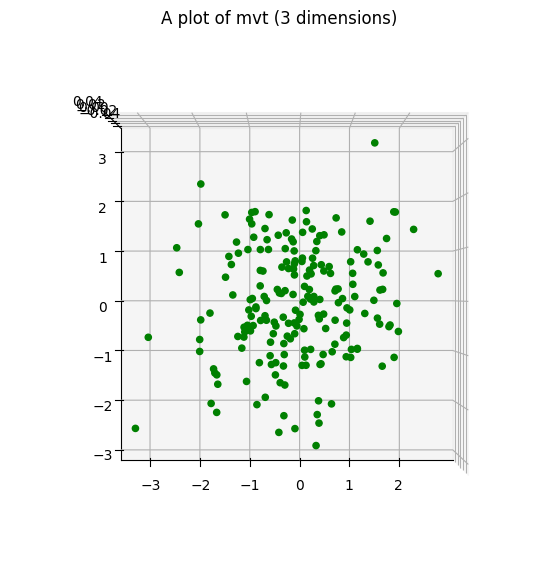

In [2]:
means = [0,0,0]
covariance = np.array([[1,0,0],[0,1,0],[0,0,0]])

samples = np.random.multivariate_normal(means, covariance, 200)
# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(samples[:,0], samples[:,1], samples[:,2], color = "green")
ax.view_init(90, -90)
plt.title("A plot of mvt (3 dimensions)")
 
# show plot
plt.show()

As expected, we have a multivariate gaussian distribution which lies in a 3-dimensional space. However, lets take another look at the plot from another angle:

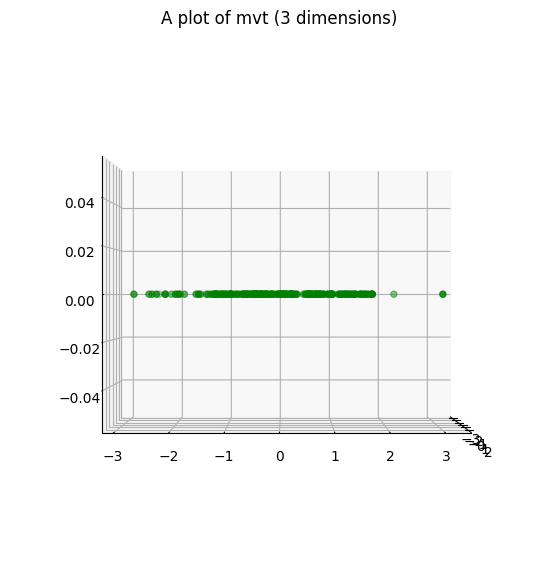

In [3]:
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 # Creating plot
ax.scatter3D(samples[:,0], samples[:,1], samples[:,2], color = "green")
ax.view_init(0, 0)
plt.title("A plot of mvt (3 dimensions)")
 
# show plot
plt.show()

What we actually have in this plot is a 3d-Gaussian distribution where the value of the z-axis (3rd dimension) is always 0. We can very easily represent this dimension as a 2d-Gaussian without losing any information about the data in the distribution. i.e. by

$$ k(x,x') =\begin{bmatrix}
    1 & 0\\
    0 & 1 \\
    \end{bmatrix}$$
    
Okay so this was an extremely trivial example right? We could see very easily from the matrix that this data always had the value 0 in the 3rd dimension. Lets make things a bit trickier. We transform the data by rotating it around the $x$ axis by 45 degrees. The rotation matrix is:

$$ R =\begin{bmatrix}
    1 & 0 & 0\\
    0 & \cos(45) & -sin(45) \\
    0 & \sin(45) & cos(45) \\
    \end{bmatrix}$$
    
We use it to transform all the "original samples" from our distribution to get the plot below:

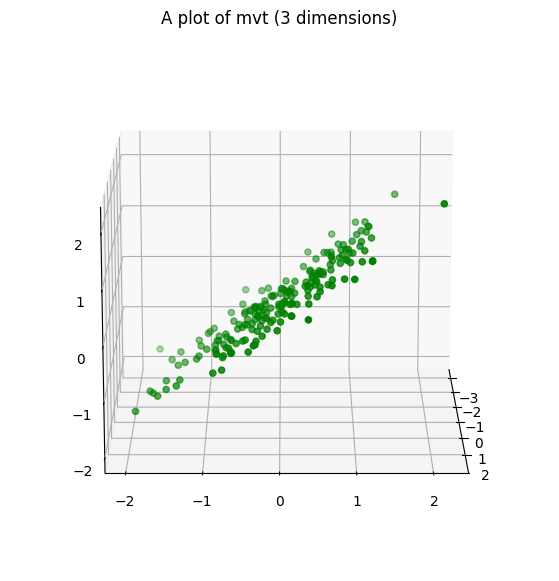

In [4]:
# Rotation around x axis by 45 degrees
R = np.array([[1, 0, 0],[0, np.cos(np.deg2rad(45)), -np.sin(np.deg2rad(45))],[0, np.sin(np.deg2rad(45)), np.cos(np.deg2rad(45))]])
new_samples = np.array([np.matmul(R,sample) for sample in samples])

fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
# Creating plot
ax.scatter3D(new_samples[:,0], new_samples[:,1], new_samples[:,2], color = "green")
ax.view_init(15, 0)
plt.title("A plot of mvt (3 dimensions)")
plt.show()

Next, we calculate the covariance matrix of our new samples using numpy to get the matrix:

In [5]:
new_cov = np.cov(new_samples.T)
print(new_cov)

[[1.01796666 0.09739499 0.09739499]
 [0.09739499 0.56359587 0.56359587]
 [0.09739499 0.56359587 0.56359587]]


Now, imagine if I came to you and asked you to plot me a multivariate gaussian distribution with means 0 and covariance matrix equal to the one above. Unless you are familiar with the tricks outlined in this document, you would probably tell me i'm crazy and that it's not possible!

Why? 

Well because the determinant of the covariance matrix is 0. If a matrix has 0 determinant, its not invertable and so we cannot calculate the normal distribution using the equation:

$$
f(\mathbf{x}; \boldsymbol{\mu}, \boldsymbol{\Sigma}) = \frac{1}{\sqrt{(2\pi)^k \lvert \boldsymbol{\Sigma} \rvert}} \exp\left(-\frac{1}{2} (\mathbf{x}-\boldsymbol{\mu})^T \boldsymbol{\Sigma}^{-1} (\mathbf{x}-\boldsymbol{\mu})\right)
$$

where $\Sigma$ is the covariance matrix.

We know already that the data was generated from a multivariate gaussian distribuion though. That is how we generated the intital covaraince matrix. So there must be a way back to that original distribution and the key lies within Principle component analysis (PCA).

## Principle Component Analysis 

The overall goal of principle component analysis is to calculate the vectors which best represent the spread of variance from our distribution. We can simply do this by calculating the eigenvectors and eigenvalues of our covariance matrix. In other words, we are calculating new basis vectors such that the variance is spread in the same directions as the basis vectors. The eigenvalue in this case represents the dimension of the basis vectors. I.e. if one eigenvalue is much bigger than the others, then the variance is spread more in the direction of its eigenvector. 

I WILL WRITE MORE HERE ONE DAY!!!

Lets calculate the eigenvalues and vectors of our new covariance matrix:

In [6]:
eigenvalues, eigenvectors = np.linalg.eig(new_cov)

print("The eigenvalues are " + str(eigenvalues))
print("The eigenvectors are:")
print(eigenvectors)

The eigenvalues are [1.22074834e+00 9.24410053e-01 7.85046229e-17]
The eigenvectors are:
[[-5.61879718e-01 -8.27218945e-01 -2.87459906e-17]
 [-5.84932125e-01  3.97308959e-01 -7.07106781e-01]
 [-5.84932125e-01  3.97308959e-01  7.07106781e-01]]


Notice something interesting here?

Look at the value of the third eigenvalue... its 0!!!

This is the key to understanding distributions in lower dimensional spaces! Although our covariance matrix had variance and covariances greater than 0 across all 3 dimensions, when we shift the basis of our space to the eigenvectors, we see that there is 0 variance in the 3rd dimension. i.e the third coordinate of our multivarite gaussian is always 0 in this new basis. 

We can take advantage of this!

If the 3rd coordinate is always 0, then why not represent the gaussian as a 2d distribution instead?
Lets try it!

As previously mentioned, the eigenvectors represent the direction of the variance and the eigenvalues represent the magnitude of that variance. Therefore, by combining the eigenvectors and values, there is a way to calcuate the covariance matrix of a lower dimension. To compute the reduced-dimensional covariance matrix, denoted as $\boldsymbol{\Sigma}_r$, we can use the following formula:


$$
\boldsymbol{\Sigma}_r = \mathbf{U}_{:,1:r} \cdot \text{diag}(\boldsymbol{\lambda}_{1:r}) \cdot \mathbf{U}_{:,1:r}^T
$$

where:
- $\mathbf{U}_{:,1:r}$ represents the first $r$ columns of the matrix $\mathbf{U}$.
- $\text{diag}(\boldsymbol{\lambda}_{1:r})$ creates a diagonal matrix with the first $r$ eigenvalues.
- $\mathbf{U}_{:,1:r}^T$ denotes the transpose of the first $r$ columns of $\mathbf{U}$.

and where r is the rank of the original matrix. In this case, r=2 since the 3rd dimension had eigenvalue 0.

We calculate this below:

In [7]:
v_prime = eigenvectors[:, 0:2] # first 2 eigenvectors
eigenvals_matrix = np.diag(eigenvalues[:2]) # diagonal matrix of first 2 eigenvalues
temp = np.matmul(eigenvals_matrix,v_prime.T)
new_covariance_matrix = np.matmul(v_prime.T,temp.T)
print("The lower dimensional covariance matrix is: ")
print(new_covariance_matrix)

The lower dimensional covariance matrix is: 
[[1.22074834e+00 5.55111512e-16]
 [6.66133815e-16 9.24410053e-01]]


Wait a second...

We have seen this before, have we not?

Oh yes, its the covariance matrix we used initially when representing our data before we applied the rotation matrix transformation to the samples. By setting new basis vectors and reducing the dimension of the rotated matrix, we got back to the original 2D representation of our data!

But our data was originally in 3 dimensions and now we don't know the true distribution looked in the real world. How do we know what the angle of the rotation was?

Now, we can generate samples from the 2D distribution and transform them using the eigenvectors back to the original 3d distribution. 

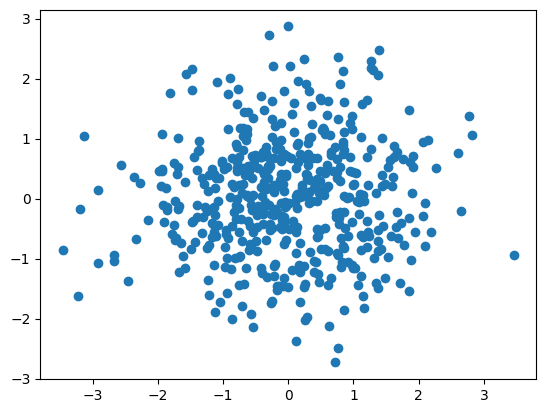

In [8]:
# Generate samples from new 2d dist

means = [0,0]
samples = np.random.multivariate_normal(means, new_covariance_matrix, 500)

plt.scatter(samples[:,0], samples[:,1])
plt.show()

And the transformed version:

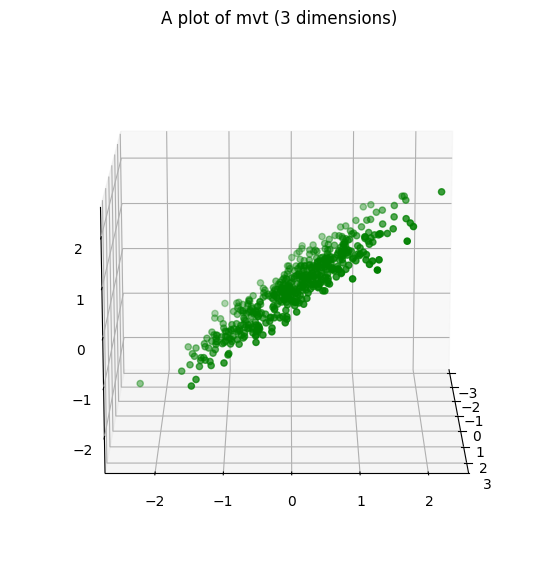

In [9]:
newsamples = np.array([np.matmul(sample, v_prime.T) for sample in samples])

fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
# Creating plot
ax.scatter3D(newsamples[:,0], newsamples[:,1], newsamples[:,2], color = "green")
ax.view_init(15, 0)
plt.title("A plot of mvt (3 dimensions)")
plt.show()

And there we have it... The original distribution!

Recap:

So far, we have took samples from a 3D gaussian distribution where the covariance was singular. We did this by:
1) using pca to reduce the dimension
2) calculating a new low dimension covariance matrix
3) generating low dimensional samples from the new covariance matrix
4) scaling the low dimensional samples using the eigenvectors to get the original distribution

## How about the 2 dimensional case?

### A demonstration of $k(x,x') = x^{T} x$



Lets say we have covariance matrix:

$$ k(x,x') =\begin{bmatrix}
    1 & 2\\
    2 & 4 \\
    \end{bmatrix}$$
    
Again, we cannot calculate the normal distribution the standard way, since we the matrix is singular. We must transform it to a lower dimension!

In [10]:
means = [0,0]
covariance = np.array([[1,2],[2,4]])

eigenvalues, eigenvectors = np.linalg.eig(covariance)

print("The eigenvalues are " + str(eigenvalues))
print("The corresponding eigenvectors are " + str(eigenvectors[:,0])+ ", "+str(eigenvectors[:,1]))

The eigenvalues are [0. 5.]
The corresponding eigenvectors are [-0.89442719  0.4472136 ], [-0.4472136  -0.89442719]


We see that there are two principal components of this data which makes sense considering its a 2-dimensional problem. The components act in the directions $[-0.89,-0.45]$ and $[-0.45,-0.89]$ with magnitudes $0$ and $5$. 

Taking the non-zero eigenvalues, $5$, we are left with a single eigenvector $[0.45,0.89]$. NOTE: Since we are considering the span of the eigenvector, we can flip it about the point $[0,0]$ i.e. take the the negative vector.

The reduced dimensional covariance matrix becomes:


$$\Sigma_r = [0.45,0.89]^T[5][0.45,0.89]$$

therefore, $\Sigma_r = 1.0125 + 3.9605 = 4.973$.

We now generate samples from a normal distribution with mean 0 and sd=$\Sigma_r$.

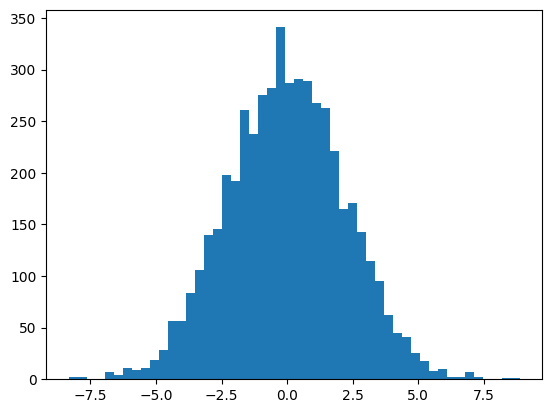

In [12]:
samples = np.random.normal(0, np.sqrt(4.973), 5000)

plt.hist(samples, bins = 50)
plt.show()

Now, we transform back up to the higher dimension by multiplying by the eigen vector!

(-6.0, 6.0)

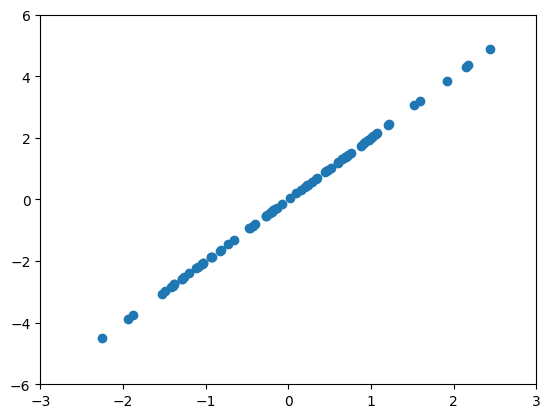

In [13]:
less_samples = np.random.normal(0, np.sqrt(4.973), 80) # in order to see samples on final scatter plot rather than solid line
v_prime = -eigenvectors[:, 1] # first 2 eigenvectors

new_samples = np.array([sample * v_prime for sample in less_samples])
plt.scatter(new_samples[:,0],new_samples[:,1])
plt.xlim([-3, 3])
plt.ylim([-6, 6])


We can compare this with the output from a direct multivariate normal function. The function is programmed to perform a similar method to this dimensionality reduction trick!

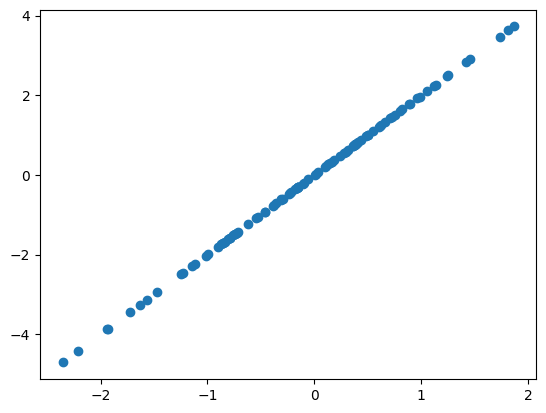

In [14]:
means = [0,0]
covariance = np.array([[1,2],[2,4]])
samples = np.random.multivariate_normal(means,covariance,100)
plt.scatter(samples[:,0],samples[:,1])
# show plot
plt.show()

And this is how we can sometimes calculate the gaussian distribution of singular covariance matrices!